In [1]:
import sys

sys.path.append("../src")

import gc
import os
import pandas as pd
import warnings
from dataclasses import asdict

import lightgbm as lgb
from dotenv import load_dotenv

import wandb
from pathlib import Path
from config import cfg
from data_process import get_dfs
from utils import WandbCallback, commit_results

warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")

cfg.train_path = Path("../data/train.csv")
cfg.test_path = Path("../data/test.csv")
cfg.pltpd_path = Path("../data/podcast_dataset.csv")


dfs = get_dfs(cfg)
X_train, y_train, X_valid, y_valid, X_test = dfs.values()
X_train = pd.concat([X_train, X_valid], axis=0)
y_train = pd.concat([y_train, y_valid], axis=0)
X_train["Listening_Time_minutes"] = y_train.to_list()
X_train

,Podcast_Name,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Episode_Num,...,Time_sin,Time_cos,Day_sin2,Day_cos2,Time_sin2,Time_cos2,Length_per_Ads,Length_per_Host,Length_per_Guest,Listening_Time_minutes
453635,44,94.30,0,97.67,4,14,53.32,2.0,2,81,...,8.572528e-16,-1.000000e+00,0.781831,0.623490,0.866025,5.000000e-01,31.433333,0.955711,1.736009,77.27788
11651,36,82.15,2,94.78,5,21,53.32,1.0,2,53,...,1.000000e+00,-4.904777e-16,0.433884,-0.900969,-1.000000,-4.286264e-16,41.075000,0.857695,1.512334,50.02839
431999,20,13.72,3,68.60,5,14,65.77,3.0,0,21,...,8.572528e-16,-1.000000e+00,0.433884,-0.900969,0.866025,5.000000e-01,3.430000,0.197126,0.205482,10.07496
529211,43,24.00,1,42.14,5,10,41.29,0.0,0,99,...,6.123234e-16,-1.000000e+00,0.433884,-0.900969,-0.866025,5.000000e-01,24.000000,0.556328,0.567510,17.82074
110925,26,63.77,7,34.10,4,21,53.32,0.0,1,15,...,1.000000e+00,-4.904777e-16,0.781831,0.623490,-1.000000,-4.286264e-16,63.770000,1.816809,1.173969,94.80341
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235496,14,75.84,5,69.94,3,10,82.82,0.0,0,13,...,6.123234e-16,-1.000000e+00,-0.781831,0.623490,-0.866025,5.000000e-01,75.840000,1.069072,0.904796,49.30995
372040,17,48.88,1,38.62,3,17,10.47,1.0,1,25,...,1.000000e+00,-7.354071e-16,-0.781831,0.623490,0.500000,-8.660254e-01,24.440000,1.233720,4.261552,39.16467
695665,11,7.36,6,88.61,2,21,0.15,0.0,1,47,...,1.000000e+00,-4.904777e-16,-0.433884,-0.900969,-1.000000,-4.286264e-16,7.360000,0.082134,6.400000,6.69428
386092,15,111.19,3,65.99,2,14,53.42,1.0,2,44,...,8.572528e-16,-1.000000e+00,-0.433884,-0.900969,0.866025,5.000000e-01,55.595000,1.659800,2.043183,75.19943


In [2]:
X_train.describe()

,Episode_Length_minutes,Host_Popularity_percentage,Guest_Popularity_percentage,Number_of_Ads,Day_sin,Day_cos,Time_sin,Time_cos,Day_sin2,Day_cos2,Time_sin2,Time_cos2,Length_per_Ads,Length_per_Host,Length_per_Guest,Listening_Time_minutes
count,797105.000000,797105.000000,797105.000000,797104.000000,797105.000000,797105.000000,7.971050e+05,7.971050e+05,797105.000000,797105.000000,797105.000000,7.971050e+05,797105.000000,797105.000000,797105.000000,797105.000000
mean,64.335595,59.877839,52.330528,1.357792,-0.014195,0.008698,5.223854e-01,-4.776146e-01,-0.020380,0.007891,-0.130144,1.331726e-02,36.081814,1.257357,2.392511,45.444668
std,31.025075,22.889880,25.653978,1.149681,0.704169,0.709838,4.994990e-01,4.994990e-01,0.705169,0.708703,0.817545,5.608091e-01,27.917537,0.886336,5.139673,27.140915
min,0.000000,1.300000,0.000000,0.000000,-0.974928,-0.900969,6.123234e-16,-1.000000e+00,-0.974928,-0.900969,-1.000000,-8.660254e-01,0.000000,0.000000,0.000000,0.000000
25%,39.350000,39.450000,34.200000,0.000000,-0.781831,-0.900969,8.572528e-16,-1.000000e+00,-0.781831,-0.900969,-1.000000,-8.660254e-01,15.942500,0.649164,0.702226,23.184220
50%,63.770000,60.060000,53.320000,1.000000,0.000000,-0.222521,1.000000e+00,-7.354071e-16,0.000000,-0.222521,0.500000,-4.286264e-16,27.866667,1.052310,1.173969,43.392270
75%,90.210000,79.560000,71.090000,2.000000,0.781831,0.623490,1.000000e+00,-4.904777e-16,0.781831,0.623490,0.500000,5.000000e-01,50.195000,1.623972,2.005707,64.814620
max,121.000000,119.460000,119.910000,103.910000,0.974928,1.000000,1.000000e+00,-4.904777e-16,0.974928,1.000000,0.866025,5.000000e-01,121.000000,23.358974,116.346535,119.970000


<Axes: >

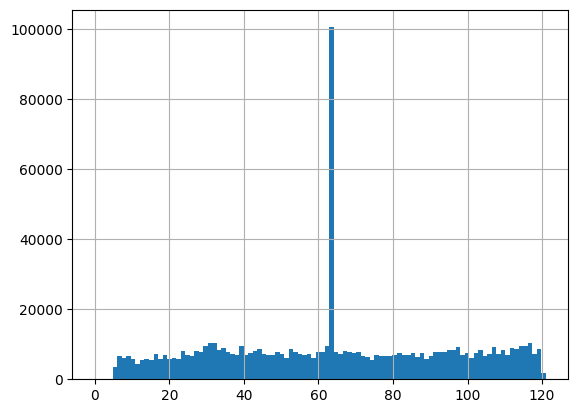

In [3]:
X_train["Episode_Length_minutes"].hist(bins=100)

<Axes: >

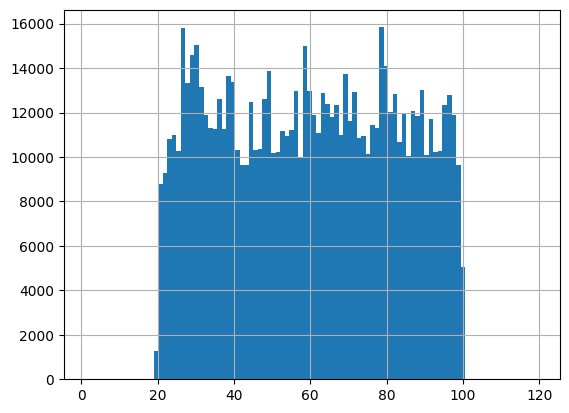

In [4]:
X_train["Host_Popularity_percentage"].hist(bins=100)

<Axes: >

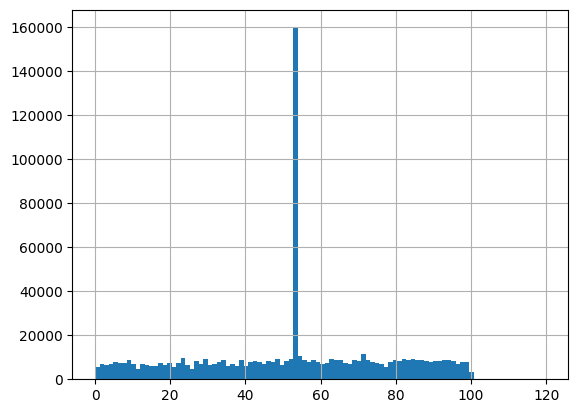

In [5]:
X_train["Guest_Popularity_percentage"].hist(bins=100)

In [16]:
grouped = X_train.groupby(["Podcast_Name"])
for i, (name, group) in enumerate(grouped):
    print(f"Group: {name}")
    display(group[["Podcast_Name", "Episode_Num", "Host_Popularity_percentage", "Guest_Popularity_percentage", "Listening_Time_minutes", "Episode_Length_minutes", "Publication_Day", "Publication_Time", "Episode_Sentiment"]])
    if i > 10:
        break


Group: (0,)


,Podcast_Name,Episode_Num,Host_Popularity_percentage,Guest_Popularity_percentage,Listening_Time_minutes,Episode_Length_minutes,Publication_Day,Publication_Time,Episode_Sentiment
717945,0,69,63.11,69.19,34.67821,63.77,5,14,0
634606,0,67,78.14,64.29,44.51052,45.51,2,10,1
310221,0,51,29.15,41.41,77.66363,117.40,3,21,1
239527,0,84,95.14,23.14,55.33630,62.93,4,21,2
164084,0,24,55.80,69.15,14.10608,17.73,6,14,0
...,...,...,...,...,...,...,...,...,...
185125,0,11,66.05,43.44,73.20842,80.65,0,17,2
235289,0,35,46.05,4.89,75.20213,95.55,1,21,2
290333,0,45,22.66,53.42,66.86169,81.53,1,21,2
703968,0,72,59.00,46.20,22.32000,33.71,6,21,0


Group: (1,)


,Podcast_Name,Episode_Num,Host_Popularity_percentage,Guest_Popularity_percentage,Listening_Time_minutes,Episode_Length_minutes,Publication_Day,Publication_Time,Episode_Sentiment
186431,1,75,41.12,34.15,0.00000,7.43,1,21,1
503016,1,28,88.09,53.32,36.00147,57.01,0,17,2
227043,1,85,80.68,49.57,19.73409,63.77,3,14,0
59962,1,92,88.83,2.77,25.67950,33.33,3,14,2
94537,1,51,52.09,61.30,67.03957,63.77,1,10,2
...,...,...,...,...,...,...,...,...,...
440115,1,46,99.32,96.32,33.68286,36.64,5,17,0
81639,1,56,60.57,33.37,20.02901,42.14,6,14,2
442764,1,51,58.18,18.41,24.32505,32.94,3,21,1
567057,1,98,97.31,45.05,16.06603,23.02,0,17,1


Group: (2,)


,Podcast_Name,Episode_Num,Host_Popularity_percentage,Guest_Popularity_percentage,Listening_Time_minutes,Episode_Length_minutes,Publication_Day,Publication_Time,Episode_Sentiment
729652,2,58,81.88,53.32,62.85679,72.31,0,14,2
333389,2,60,97.98,53.32,58.65527,87.85,5,14,0
101619,2,81,95.40,47.33,33.25283,53.71,3,17,0
742496,2,92,79.57,4.57,13.44077,19.78,0,14,1
478093,2,73,37.41,51.39,40.41585,63.77,4,14,1
...,...,...,...,...,...,...,...,...,...
503377,2,85,28.63,53.42,42.12630,58.70,3,14,1
101631,2,94,63.76,53.42,6.82015,6.80,0,10,1
23566,2,26,20.19,90.19,14.19832,30.82,5,10,1
333446,2,31,28.23,70.29,1.79949,15.44,2,14,2


Group: (3,)


,Podcast_Name,Episode_Num,Host_Popularity_percentage,Guest_Popularity_percentage,Listening_Time_minutes,Episode_Length_minutes,Publication_Day,Publication_Time,Episode_Sentiment
279896,3,84,23.53,34.69,20.29680,44.59,0,14,1
406249,3,28,26.77,86.18,47.04000,83.90,3,10,0
310908,3,81,37.34,28.53,29.17657,46.32,0,17,1
388955,3,100,59.39,66.97,39.31971,63.77,6,14,2
436101,3,60,62.93,51.03,47.31234,82.15,6,14,0
...,...,...,...,...,...,...,...,...,...
735016,3,5,83.49,23.05,76.83493,100.59,6,14,0
78699,3,83,56.12,82.15,13.01004,15.98,2,17,0
367407,3,93,75.19,57.08,39.60044,77.78,0,14,0
487770,3,32,66.81,96.76,48.11281,84.15,1,10,0


Group: (4,)


,Podcast_Name,Episode_Num,Host_Popularity_percentage,Guest_Popularity_percentage,Listening_Time_minutes,Episode_Length_minutes,Publication_Day,Publication_Time,Episode_Sentiment
448558,4,21,35.02,13.80,25.24877,59.31,0,14,1
18592,4,33,97.35,53.32,62.99733,97.89,2,14,1
333044,4,21,58.47,53.76,22.58562,53.71,6,21,1
399360,4,79,26.98,14.41,16.28633,26.58,2,17,0
334764,4,94,94.64,53.32,115.18000,118.15,6,21,0
...,...,...,...,...,...,...,...,...,...
200817,4,82,29.45,93.17,13.25110,18.73,3,10,0
179974,4,4,95.84,30.77,106.97679,117.61,2,10,1
406665,4,26,63.38,86.40,20.41581,34.00,6,14,0
303825,4,41,20.17,53.42,63.95245,88.30,2,10,0


Group: (5,)


,Podcast_Name,Episode_Num,Host_Popularity_percentage,Guest_Popularity_percentage,Listening_Time_minutes,Episode_Length_minutes,Publication_Day,Publication_Time,Episode_Sentiment
726597,5,56,84.23,9.30,62.26029,73.90,4,14,2
226259,5,98,67.76,98.04,20.03000,63.77,1,17,0
383245,5,72,44.63,61.34,25.68000,42.69,3,21,0
119950,5,8,63.55,68.53,39.83274,79.02,6,10,1
187258,5,76,27.77,44.34,60.81062,106.54,1,17,2
...,...,...,...,...,...,...,...,...,...
719482,5,3,51.91,42.27,25.37221,34.74,0,21,1
233762,5,99,39.89,52.47,85.62562,112.19,2,17,0
479079,5,65,99.59,85.69,8.32856,8.83,4,21,1
560340,5,9,47.27,93.67,50.82565,57.07,2,10,0


Group: (6,)


,Podcast_Name,Episode_Num,Host_Popularity_percentage,Guest_Popularity_percentage,Listening_Time_minutes,Episode_Length_minutes,Publication_Day,Publication_Time,Episode_Sentiment
308803,6,69,98.38,99.69,53.45000,72.63,3,17,0
135626,6,87,66.96,63.57,25.85962,32.01,2,14,1
140373,6,44,57.09,78.19,62.65869,87.26,0,14,0
712497,6,60,79.65,53.32,62.09088,72.74,5,21,2
145952,6,74,32.53,10.41,97.40499,115.35,6,14,1
...,...,...,...,...,...,...,...,...,...
436879,6,6,90.24,6.97,49.81868,68.03,3,10,1
261735,6,21,34.44,64.16,80.62076,89.02,6,14,0
731037,6,74,30.29,81.47,2.78030,7.36,2,14,2
12689,6,84,27.74,19.38,88.25831,96.38,2,14,0


Group: (7,)


,Podcast_Name,Episode_Num,Host_Popularity_percentage,Guest_Popularity_percentage,Listening_Time_minutes,Episode_Length_minutes,Publication_Day,Publication_Time,Episode_Sentiment
361877,7,79,90.15,87.94,68.59336,115.78,0,14,0
11766,7,87,66.39,49.61,37.30112,62.85,5,10,1
244035,7,83,88.31,71.51,0.00000,7.41,6,14,0
377637,7,79,71.87,29.43,24.46340,32.07,1,17,0
714296,7,48,78.74,79.69,42.89000,69.01,1,21,1
...,...,...,...,...,...,...,...,...,...
5399,7,67,34.50,49.92,26.21177,63.79,1,14,1
110761,7,73,22.63,58.63,4.06257,63.79,2,14,1
522736,7,30,30.90,63.33,15.19602,41.12,0,21,0
68212,7,92,37.12,16.82,41.56316,44.27,1,10,2


Group: (8,)


,Podcast_Name,Episode_Num,Host_Popularity_percentage,Guest_Popularity_percentage,Listening_Time_minutes,Episode_Length_minutes,Publication_Day,Publication_Time,Episode_Sentiment
581306,8,63,38.73,50.95,7.73000,16.69,3,10,0
399919,8,40,96.55,53.32,30.03078,63.77,2,14,0
739494,8,43,54.29,45.91,22.66640,32.73,4,10,1
7082,8,68,96.60,53.32,45.11747,46.02,3,10,1
470911,8,36,52.93,67.57,11.40255,18.45,4,21,0
...,...,...,...,...,...,...,...,...,...
729311,8,87,82.48,13.54,47.48804,64.93,2,10,2
686657,8,94,21.83,52.45,8.74669,13.67,5,14,1
731489,8,17,87.30,52.27,84.72968,107.95,1,14,1
530393,8,62,30.15,53.42,9.14022,20.18,6,10,1


Group: (9,)


,Podcast_Name,Episode_Num,Host_Popularity_percentage,Guest_Popularity_percentage,Listening_Time_minutes,Episode_Length_minutes,Publication_Day,Publication_Time,Episode_Sentiment
254177,9,49,91.53,78.17,109.41104,116.34,4,10,2
269588,9,40,30.66,0.60,77.62903,111.88,4,10,0
548794,9,86,78.95,12.70,60.10817,80.06,0,21,2
429417,9,24,65.80,71.52,53.94979,90.61,6,10,2
173812,9,91,89.44,47.19,32.31576,65.75,6,17,2
...,...,...,...,...,...,...,...,...,...
641012,9,1,37.88,15.54,77.21948,98.21,0,17,1
305001,9,15,93.57,53.42,80.56127,93.82,6,10,0
26446,9,49,25.82,71.27,48.03997,50.84,4,10,1
481931,9,58,59.71,53.42,4.65467,63.79,2,17,2


Group: (10,)


,Podcast_Name,Episode_Num,Host_Popularity_percentage,Guest_Popularity_percentage,Listening_Time_minutes,Episode_Length_minutes,Publication_Day,Publication_Time,Episode_Sentiment
37452,10,43,52.92,29.77,75.87938,63.77,5,10,0
290171,10,4,74.41,16.38,70.84232,113.46,2,21,1
104157,10,82,88.02,53.32,28.20507,33.81,4,17,2
335338,10,11,53.98,53.32,45.81937,53.74,4,21,2
145331,10,42,29.77,52.26,19.54357,43.48,0,10,0
...,...,...,...,...,...,...,...,...,...
543149,10,71,74.69,85.82,51.78029,75.89,0,21,2
422777,10,53,85.39,53.42,6.76817,14.85,0,21,0
558654,10,84,91.04,91.48,66.10961,98.12,2,14,1
261482,10,69,81.81,39.53,35.09223,47.13,3,17,0


Group: (11,)


,Podcast_Name,Episode_Num,Host_Popularity_percentage,Guest_Popularity_percentage,Listening_Time_minutes,Episode_Length_minutes,Publication_Day,Publication_Time,Episode_Sentiment
41333,11,51,79.07,53.21,33.97631,63.26,6,14,2
626942,11,57,85.35,83.85,55.71844,88.97,6,17,0
653004,11,22,78.99,97.92,90.81754,94.14,0,17,0
531151,11,99,48.78,97.56,11.95899,15.15,0,21,2
273431,11,29,96.59,44.23,26.50840,32.07,5,17,1
...,...,...,...,...,...,...,...,...,...
211181,11,30,37.39,24.39,71.56450,93.96,0,17,2
268336,11,87,34.90,72.33,85.05768,92.66,0,10,0
357077,11,11,55.54,62.26,30.26178,65.11,4,14,2
62827,11,11,93.96,25.59,38.89266,59.35,0,17,0


In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


# Calculate mean for each podcast group
columns = [
    "Podcast_Name", "Episode_Num", "Host_Popularity_percentage", 
    "Guest_Popularity_percentage", "Listening_Time_minutes", 
    "Episode_Length_minutes", "Publication_Day", 
    "Publication_Time", "Episode_Sentiment"
]

tmp_df = X_train[columns].copy()
tmp_df["Podcast_Name"] = tmp_df["Podcast_Name"].astype("int")
tmp_df["Episode_Num"] = tmp_df["Episode_Num"].astype("int")
tmp_df["Publication_Day"] = tmp_df["Publication_Day"].astype("int")
tmp_df["Publication_Time"] = tmp_df["Publication_Time"].astype("int")
tmp_df["Episode_Sentiment"] = tmp_df["Episode_Sentiment"].astype("int")

def plot_histogram():
    # Get columns to plot (exclude Podcast_Name since it's the index)
    plot_columns = grouped_mean.columns

    # Calculate how many subplots we need
    n_cols = 3
    n_rows = (len(plot_columns) + n_cols - 1) // n_cols

    # Set up figure for histograms
    plt.figure(figsize=(15, 10))

    # Loop through columns and create histograms with more detail
    for i, column in enumerate(plot_columns):
        # Check if we're trying to create more subplots than we have columns
        if i < len(plot_columns):
            plt.subplot(n_rows, n_cols, i+1)
            
            # Create histogram with KDE, using default color
            sns.histplot(grouped_mean[column], kde=True)
            
            # Add mean line
            plt.axvline(grouped_mean[column].mean(), color='red', linestyle='--', linewidth=1.5, 
                        label=f'Mean: {grouped_mean[column].mean():.2f}')
            
            # Add median line
            plt.axvline(grouped_mean[column].median(), color='green', linestyle='-.', linewidth=1.5,
                        label=f'Median: {grouped_mean[column].median():.2f}')
            
            plt.title(f'Mean {column}')
            plt.xlabel(column)
            plt.ylabel('Frequency')
            plt.legend(fontsize=8)

    plt.tight_layout()
    plt.show()


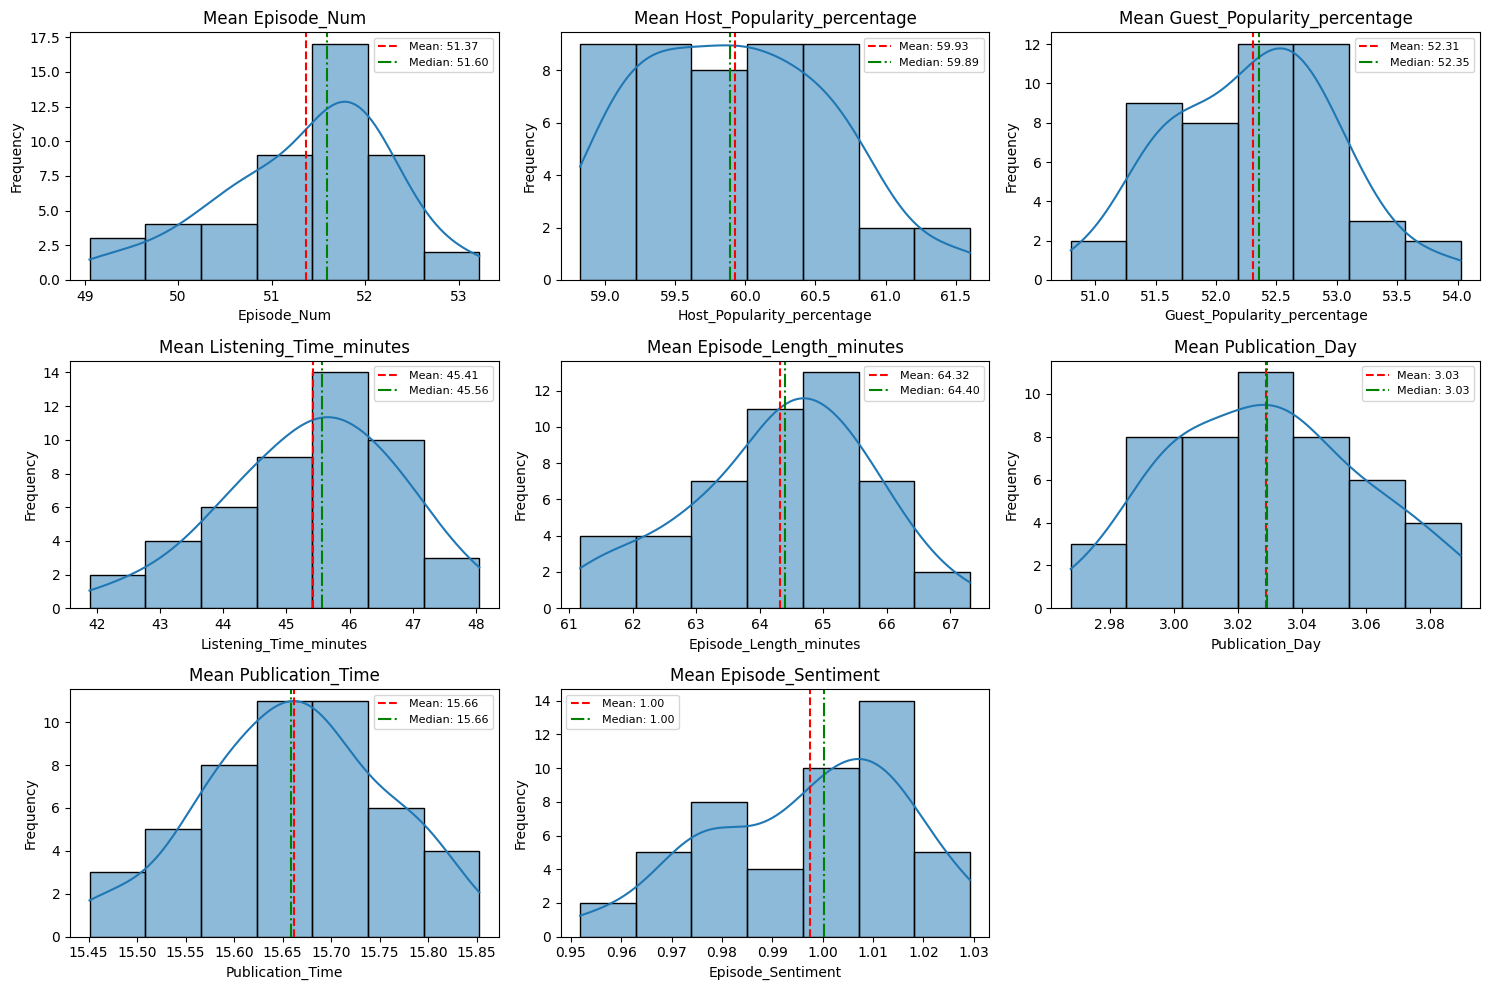

In [43]:
grouped_mean = tmp_df.groupby("Podcast_Name").mean()
plot_histogram()

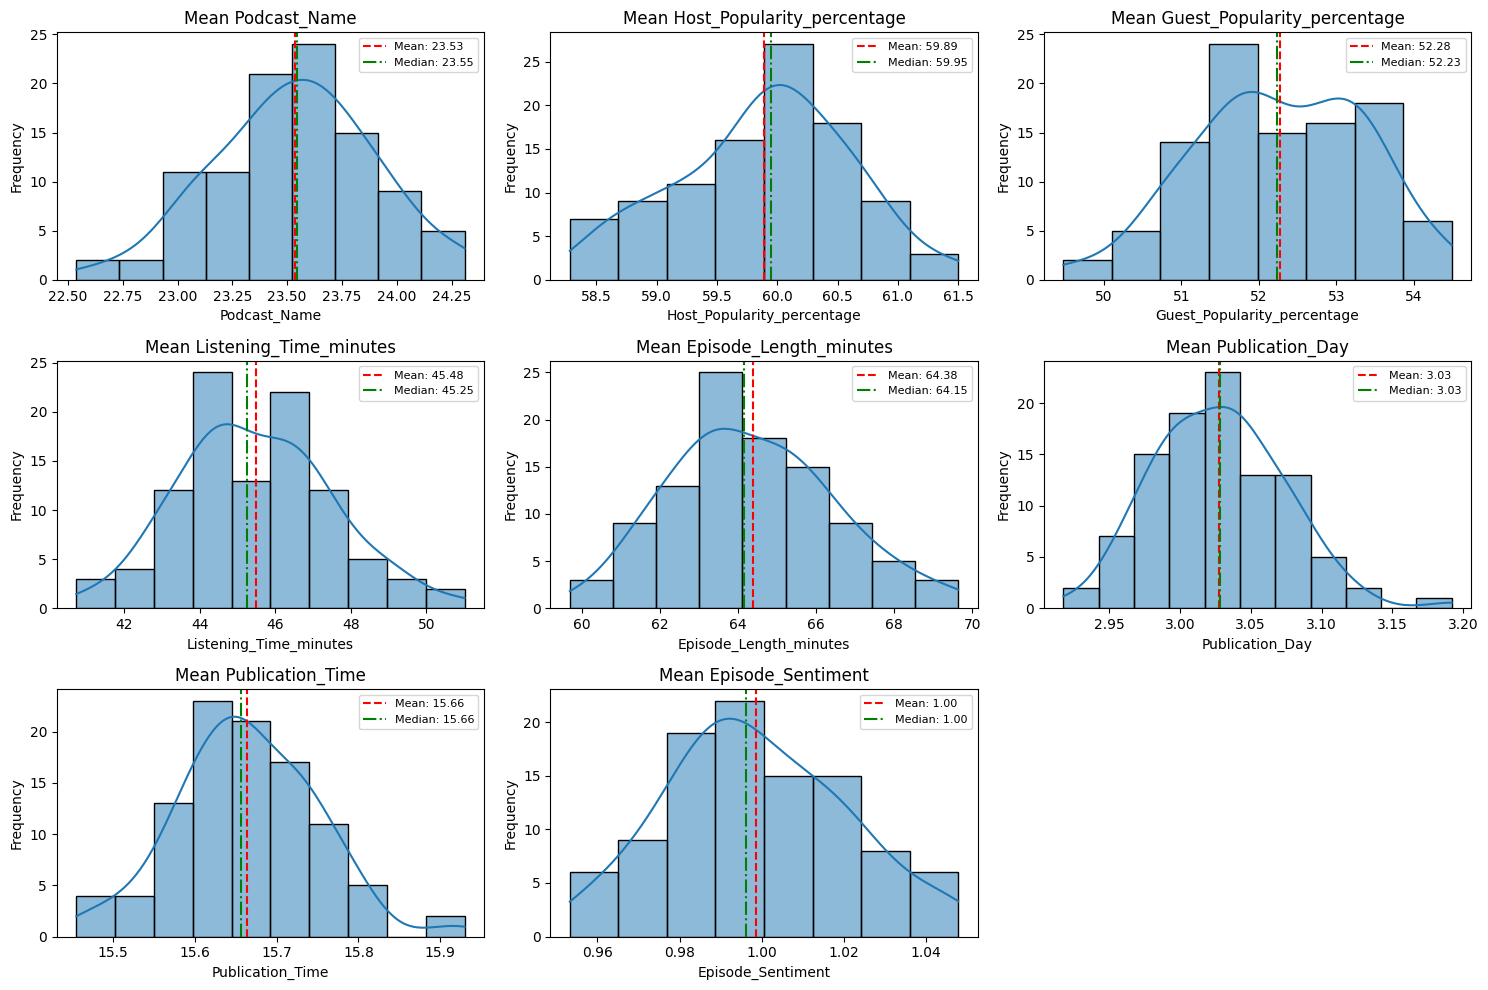

In [44]:
grouped_mean = tmp_df.groupby("Episode_Num").mean()
plot_histogram()

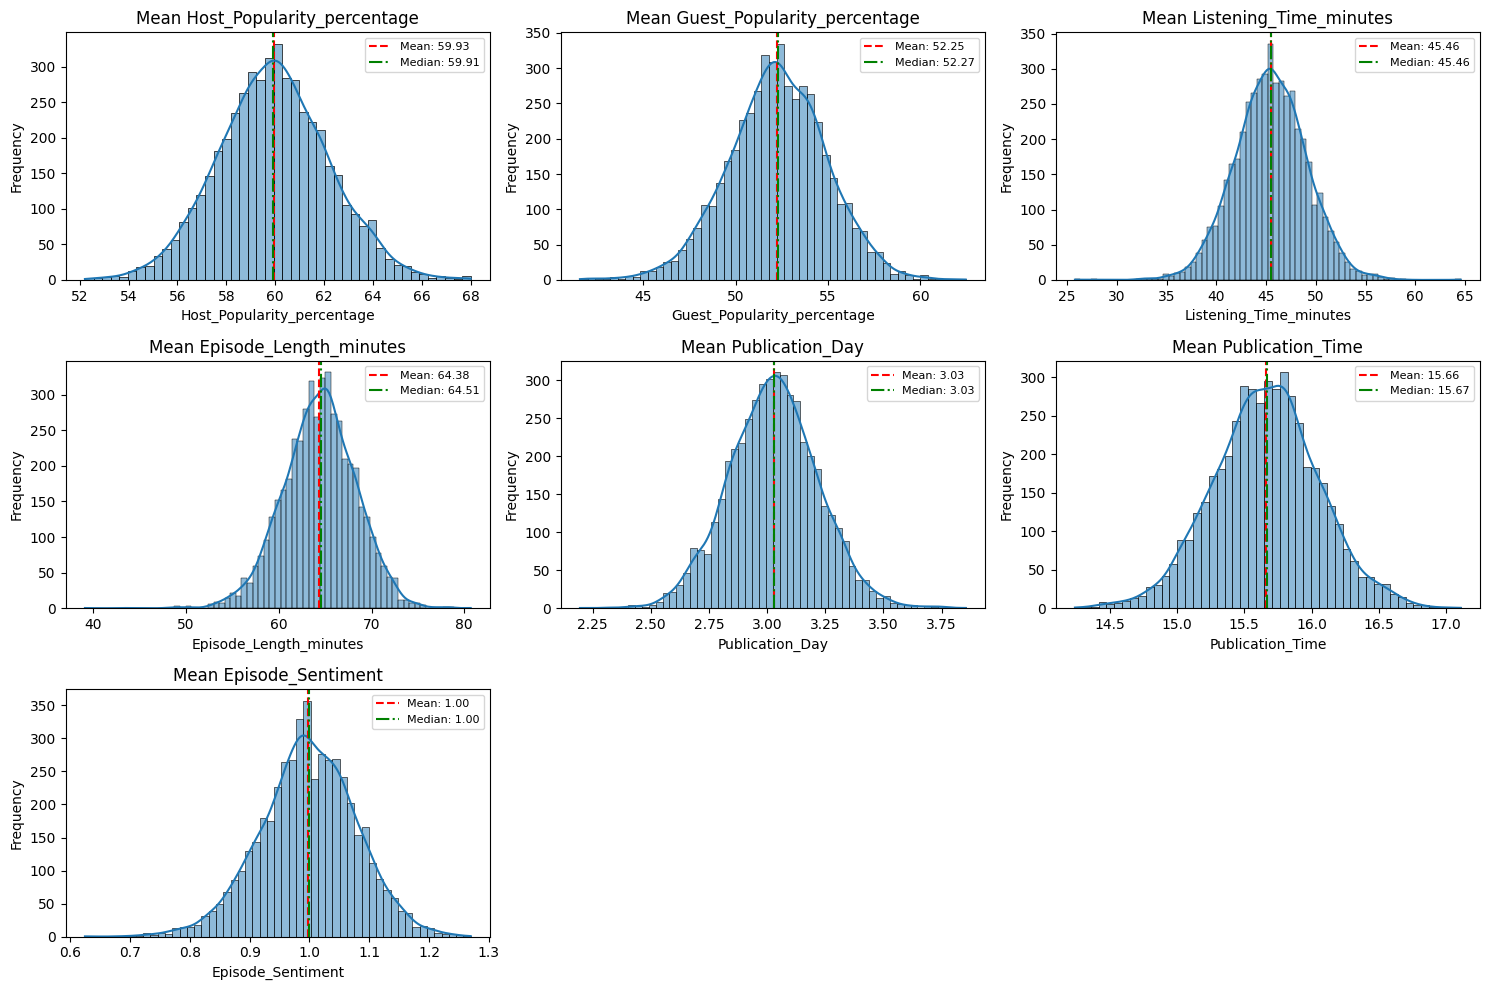

In [ ]:
grouped_mean = tmp_df.groupby(["Podcast_Name", "Episode_Num"]).mean()
plot_histogram()

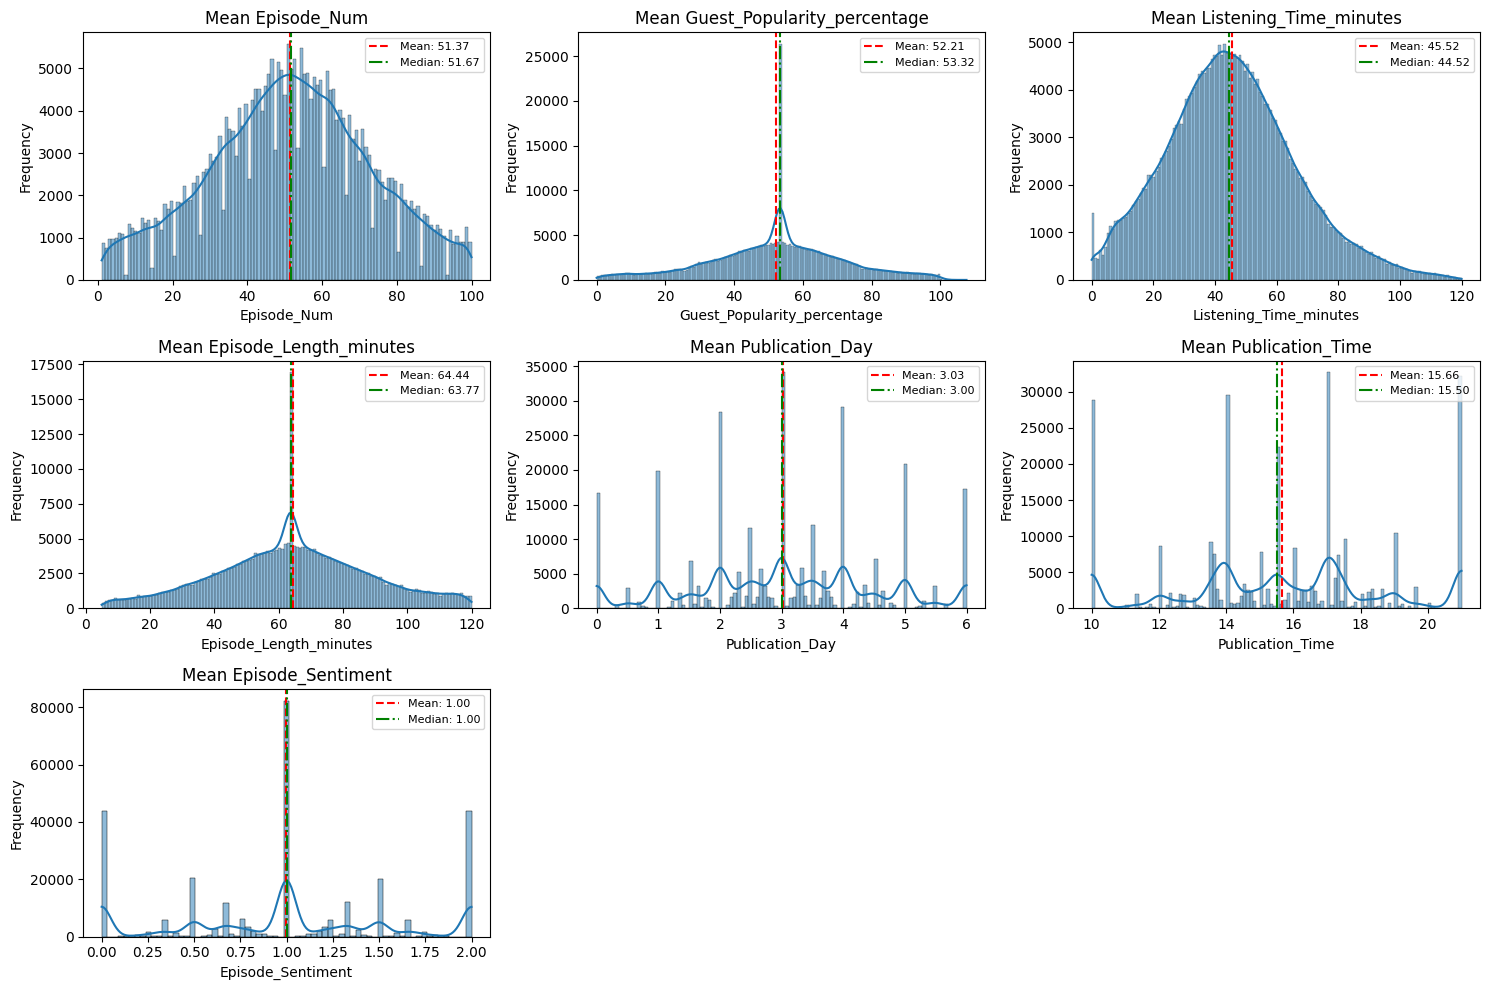

In [46]:
grouped_mean = tmp_df.groupby(["Podcast_Name", "Host_Popularity_percentage"]).mean()
plot_histogram()

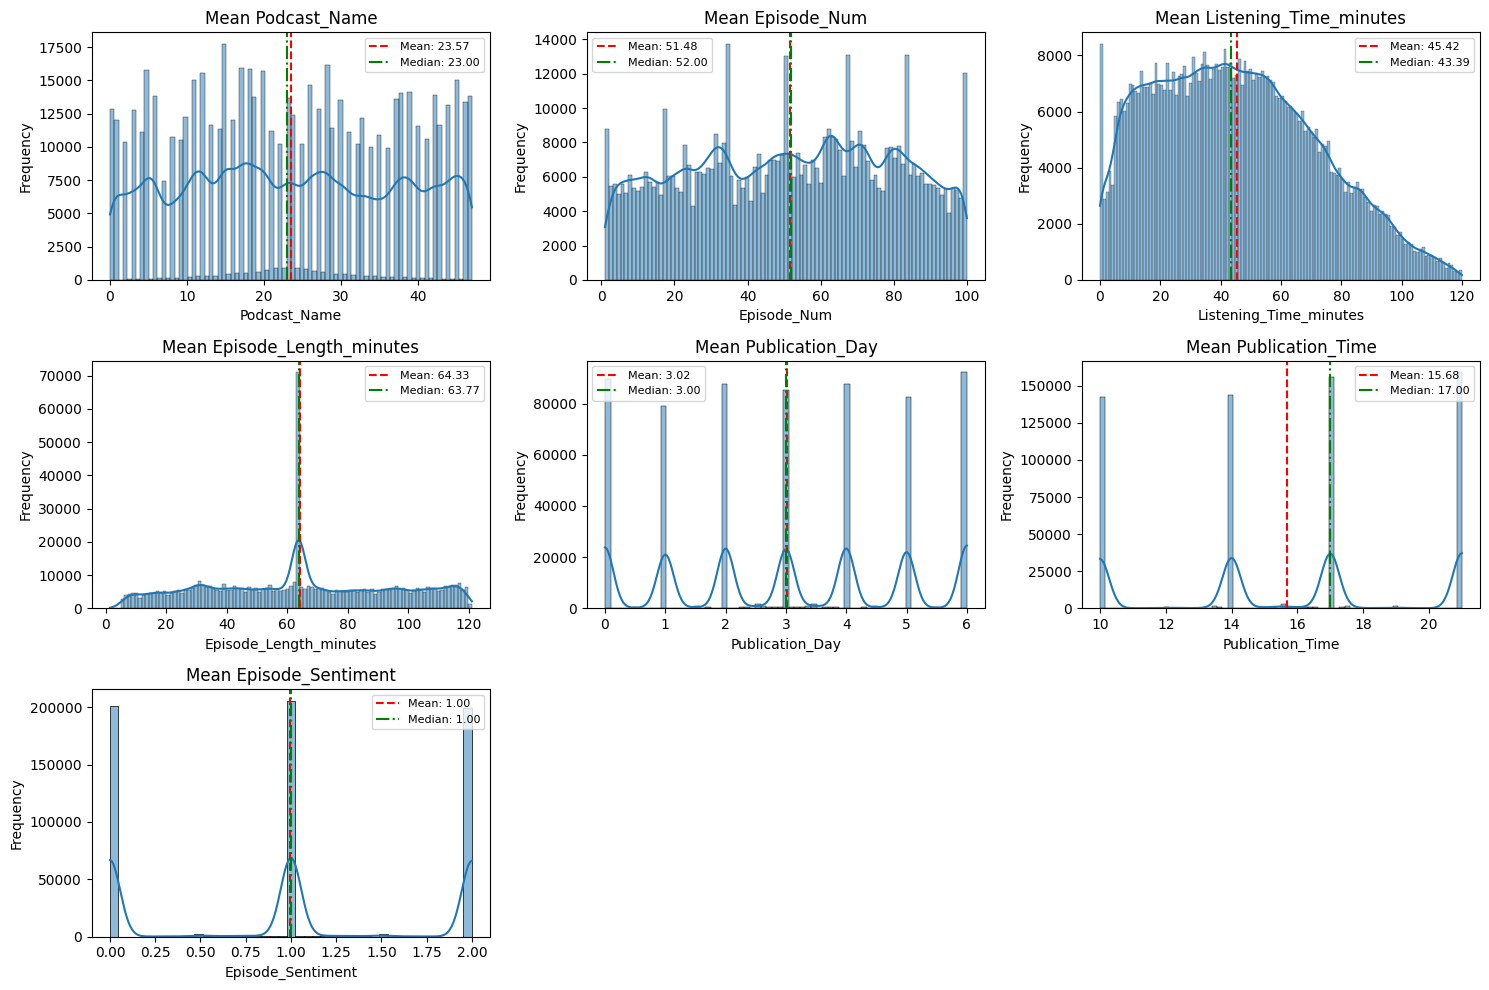

In [47]:
grouped_mean = tmp_df.groupby(["Host_Popularity_percentage", "Guest_Popularity_percentage"]).mean()
plot_histogram()

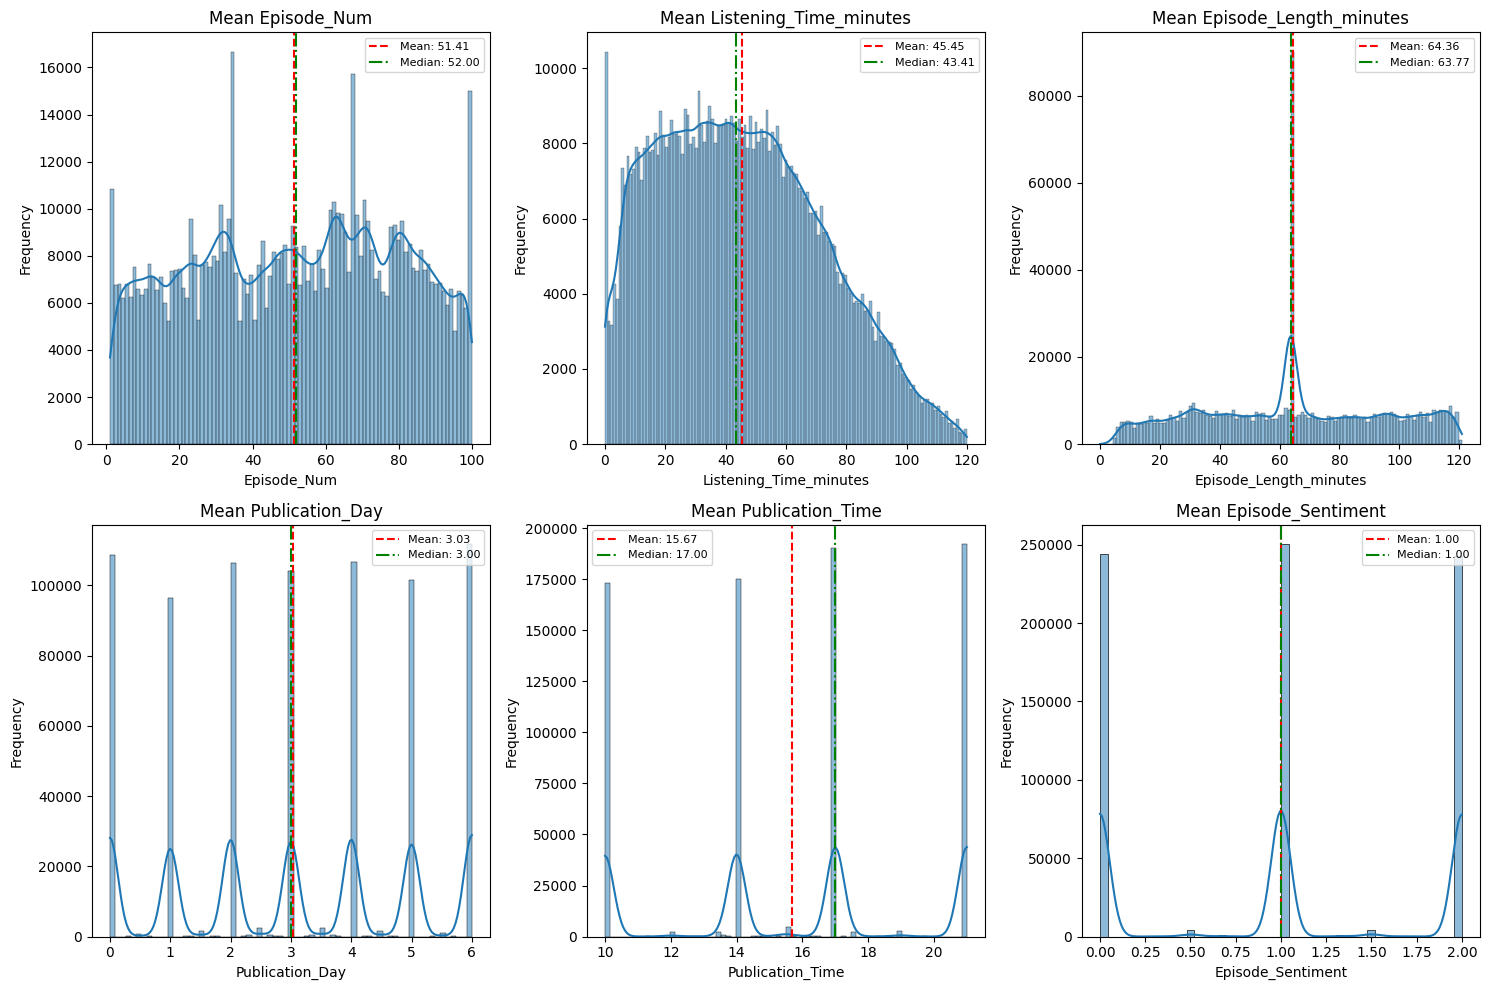

In [48]:
grouped_mean = tmp_df.groupby(["Podcast_Name", "Host_Popularity_percentage", "Guest_Popularity_percentage"]).mean()
plot_histogram()